In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import rc
from pylab import rcParams
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [2]:
%matplotlib inline
%config InlineBackend. figure_format='retina'
sns.set(style='darkgrid', palette='muted', font_scale=1.2, rc={"axes.facecolor": "#2E2E2E", "axes.grid": True, "grid.color": "#333333", "axes.edgecolor": "#424242"})
color_pal = ['#FF6E40', '#FFEA00', '#1DE9B6', '#00E5FF', '#D500F9']
sns.set_palette(sns.color_palette(color_pal))
rcParams['figure.figsize' ] = 14, 7
rcParams['text.color'] = 'black'       # Titles and text
rcParams['axes.labelcolor'] = 'white'  # Axis labels
rcParams['xtick.color'] = 'black'      # X-axis tick labels
rcParams['ytick.color'] = 'black'
tqdm. pandas ()

In [11]:
pd_ep = pd.read_csv('../Datasets/GlobusComputeDataset-v1-endpoints.csv')
pd_func = pd.read_csv('../Datasets/GlobusComputeDataset-v1-functions.csv')
pd_task = pd.read_csv('../Datasets/GlobusComputeDataset-v1-tasks.csv')
print(pd_ep.shape, pd_func.shape, pd_task.shape)

(580, 3) (277386, 5) (2121472, 11)


In [12]:
pd_ep.columns, pd_func.columns, pd_task.columns

(Index(['endpoint_uuid', 'endpoint_type', 'endpoint_version'], dtype='object'),
 Index(['function_uuid', 'function_body_uuid', 'loc', 'cyc_complexity',
        'num_of_imports'],
       dtype='object'),
 Index(['task_uuid', 'function_uuid', 'endpoint_uuid', 'anonymized_user_uuid',
        'argument_size', 'received', 'waiting_for_nodes', 'waiting_for_launch',
        'execution_start', 'execution_end', 'result_received'],
       dtype='object'))

In [13]:
# Merge pd_task with pd_func on 'function_uuid'
df = pd_task.merge(pd_func, on='function_uuid', how='left')

# Merge the result with pd_ep on 'endpoint_uuid'
df = df.merge(pd_ep, on='endpoint_uuid', how='left')

# Convert timestamps to datetime format
time_cols = ['received', 'waiting_for_nodes', 'waiting_for_launch', 'execution_start', 'execution_end', 'result_received']
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [14]:
df.shape

(2121472, 17)

In [15]:
df.columns

Index(['task_uuid', 'function_uuid', 'endpoint_uuid', 'anonymized_user_uuid',
       'argument_size', 'received', 'waiting_for_nodes', 'waiting_for_launch',
       'execution_start', 'execution_end', 'result_received',
       'function_body_uuid', 'loc', 'cyc_complexity', 'num_of_imports',
       'endpoint_type', 'endpoint_version'],
      dtype='object')

In [16]:
df = df[['received', 'waiting_for_nodes', 'waiting_for_launch', 'execution_start', 'execution_end', 'result_received', 'loc', 'cyc_complexity', 'argument_size', 'num_of_imports', 'endpoint_type']]
df.head()

,received,waiting_for_nodes,waiting_for_launch,execution_start,execution_end,result_received,loc,cyc_complexity,argument_size,num_of_imports,endpoint_type
0,2023-05-31 17:04:20.946309120,2023-05-31 17:04:20.967399680,2023-05-31 17:04:20.968085504,2023-05-31 17:04:20.968678656,2023-05-31 17:04:20.969150464,2023-05-31 17:04:21.046120704,3.0,1.0,659.0,0.0,LocalProvider
1,NaT,2023-05-17 13:02:42.568928256,2023-05-17 13:02:42.578729216,2023-05-17 13:02:42.583241984,2023-05-17 13:02:45.561812480,2023-05-17 13:02:45.655378432,NaN,NaN,6054.0,NaN,CobaltProvider
2,2023-06-13 04:15:41.712687104,2023-06-13 04:15:41.737238016,2023-06-13 04:15:41.740535808,2023-06-13 04:15:41.741350400,2023-06-13 04:15:41.741570048,2023-06-13 04:15:48.418417664,2.0,1.0,46.0,0.0,LocalProvider
3,2023-06-13 20:14:42.384588288,2023-06-13 20:14:42.414622464,2023-06-13 20:14:42.415176704,2023-06-13 20:14:42.415944704,2023-06-13 20:14:42.416192000,2023-06-13 20:14:48.849355264,2.0,1.0,46.0,0.0,LocalProvider
4,2023-05-17 15:44:04.291052032,2023-05-17 15:44:04.302358784,2023-05-17 15:44:04.311589888,2023-05-17 15:44:04.316283904,2023-05-17 15:44:04.641264640,2023-05-17 15:44:04.691477504,NaN,NaN,11433.0,NaN,CobaltProvider


In [17]:
df=df.ffill()
df.isna().sum()

received              0
waiting_for_nodes     0
waiting_for_launch    0
execution_start       0
execution_end         0
result_received       0
loc                   0
cyc_complexity        0
argument_size         0
num_of_imports        0
endpoint_type         0
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121472 entries, 0 to 2121471
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   received            datetime64[ns]
 1   waiting_for_nodes   datetime64[ns]
 2   waiting_for_launch  datetime64[ns]
 3   execution_start     datetime64[ns]
 4   execution_end       datetime64[ns]
 5   result_received     datetime64[ns]
 6   loc                 float64       
 7   cyc_complexity      float64       
 8   argument_size       float64       
 9   num_of_imports      float64       
 10  endpoint_type       object        
dtypes: datetime64[ns](6), float64(4), object(1)
memory usage: 178.0+ MB


In [19]:
df['execution_time'] = (df['execution_end'] - df['execution_start']).dt.total_seconds()*1000
df['queue_waiting_time'] = (df['execution_start'] - df['received']).dt.total_seconds()*1000
df['node_allocation_delay'] = (df['waiting_for_nodes'] - df['received']).dt.total_seconds()*1000
df['launch_delay'] = (df['execution_start'] - df['waiting_for_launch']).dt.total_seconds()*1000
df['result_transfer_time'] = (df['result_received'] - df['execution_end']).dt.total_seconds()*1000
df['turnaround_time'] = (df['result_received'] - df['received']).dt.total_seconds()*1000

In [20]:
df['month'] = df['received'].dt.month
df['day'] = df['received'].dt.day
df['hour'] = df['received'].dt.hour
df['minute'] = df['received'].dt.minute 
df['day_of_week'] = df['received'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [21]:
df.columns

Index(['received', 'waiting_for_nodes', 'waiting_for_launch',
       'execution_start', 'execution_end', 'result_received', 'loc',
       'cyc_complexity', 'argument_size', 'num_of_imports', 'endpoint_type',
       'execution_time', 'queue_waiting_time', 'node_allocation_delay',
       'launch_delay', 'result_transfer_time', 'turnaround_time', 'month',
       'day', 'hour', 'minute', 'day_of_week', 'is_weekend'],
      dtype='object')

In [22]:
df= df[['received', 'month', 'day', 'hour', 'minute', 'day_of_week', 'is_weekend', 'execution_time', 'queue_waiting_time', 'node_allocation_delay', 'launch_delay', 'result_transfer_time', 'turnaround_time', 'loc', 'cyc_complexity', 'argument_size', 'num_of_imports', 'endpoint_type', ]]
df.head()

,received,month,day,hour,minute,day_of_week,is_weekend,execution_time,queue_waiting_time,node_allocation_delay,launch_delay,result_transfer_time,turnaround_time,loc,cyc_complexity,argument_size,num_of_imports,endpoint_type
0,2023-05-31 17:04:20.946309120,5,31,17,4,2,0,0.471808,2.236954e+01,2.109056e+01,0.593152,76.970240,9.981158e+01,3.0,1.0,659.0,0.0,LocalProvider
1,2023-05-31 17:04:20.946309120,5,31,17,4,2,0,2978.570496,-1.224098e+09,-1.224098e+09,4.512768,93.565952,-1.224095e+09,3.0,1.0,6054.0,0.0,CobaltProvider
2,2023-06-13 04:15:41.712687104,6,13,4,15,1,0,0.219648,2.866330e+01,2.455091e+01,0.814592,6676.847616,6.705731e+03,2.0,1.0,46.0,0.0,LocalProvider
3,2023-06-13 20:14:42.384588288,6,13,20,14,1,0,0.247296,3.135642e+01,3.003418e+01,0.768000,6433.163264,6.464767e+03,2.0,1.0,46.0,0.0,LocalProvider
4,2023-05-17 15:44:04.291052032,5,17,15,44,2,0,324.980736,2.523187e+01,1.130675e+01,4.694016,50.212864,4.004255e+02,2.0,1.0,11433.0,0.0,CobaltProvider


In [23]:
df = pd.get_dummies(df, columns=['endpoint_type'], prefix='endpoint')

In [24]:
df = df.sort_values(by='received').reset_index(drop=True) 
df['inter_arrival_time'] = df['received'].diff().dt.total_seconds() 
df = df.dropna()
df = df[df.columns.values[1:]]

In [25]:
df.head()

,month,day,hour,minute,day_of_week,is_weekend,execution_time,queue_waiting_time,node_allocation_delay,launch_delay,...,num_of_imports,endpoint_CobaltProvider,endpoint_GlobusComputeEngine,endpoint_KubernetesProvider,endpoint_LSFProvider,endpoint_LocalProvider,endpoint_PBSProProvider,endpoint_SlurmProvider,endpoint_ThreadPoolEngine,inter_arrival_time
1,11,28,0,0,0,0,0.605184,1.284138e+10,1.284138e+10,1.356288e+00,...,1.0,False,False,False,False,True,False,False,False,31.061720
2,11,28,0,0,0,0,2056.022272,1.130722e+10,1.130722e+10,3.486464e+00,...,1.0,False,False,False,False,True,False,False,False,3.834512
3,11,28,0,1,0,0,511.137280,1.293543e+10,1.293542e+10,3.709952e+00,...,1.0,False,False,False,False,True,False,False,False,59.550405
4,11,28,0,1,0,0,85664.210432,3.626034e+09,1.231122e+10,-8.685196e+09,...,1.0,False,False,False,False,True,False,False,False,0.198382
5,11,28,0,2,0,0,51.764224,9.362253e+09,3.753660e+09,1.007872e+00,...,1.0,False,False,False,False,True,False,False,False,29.881877


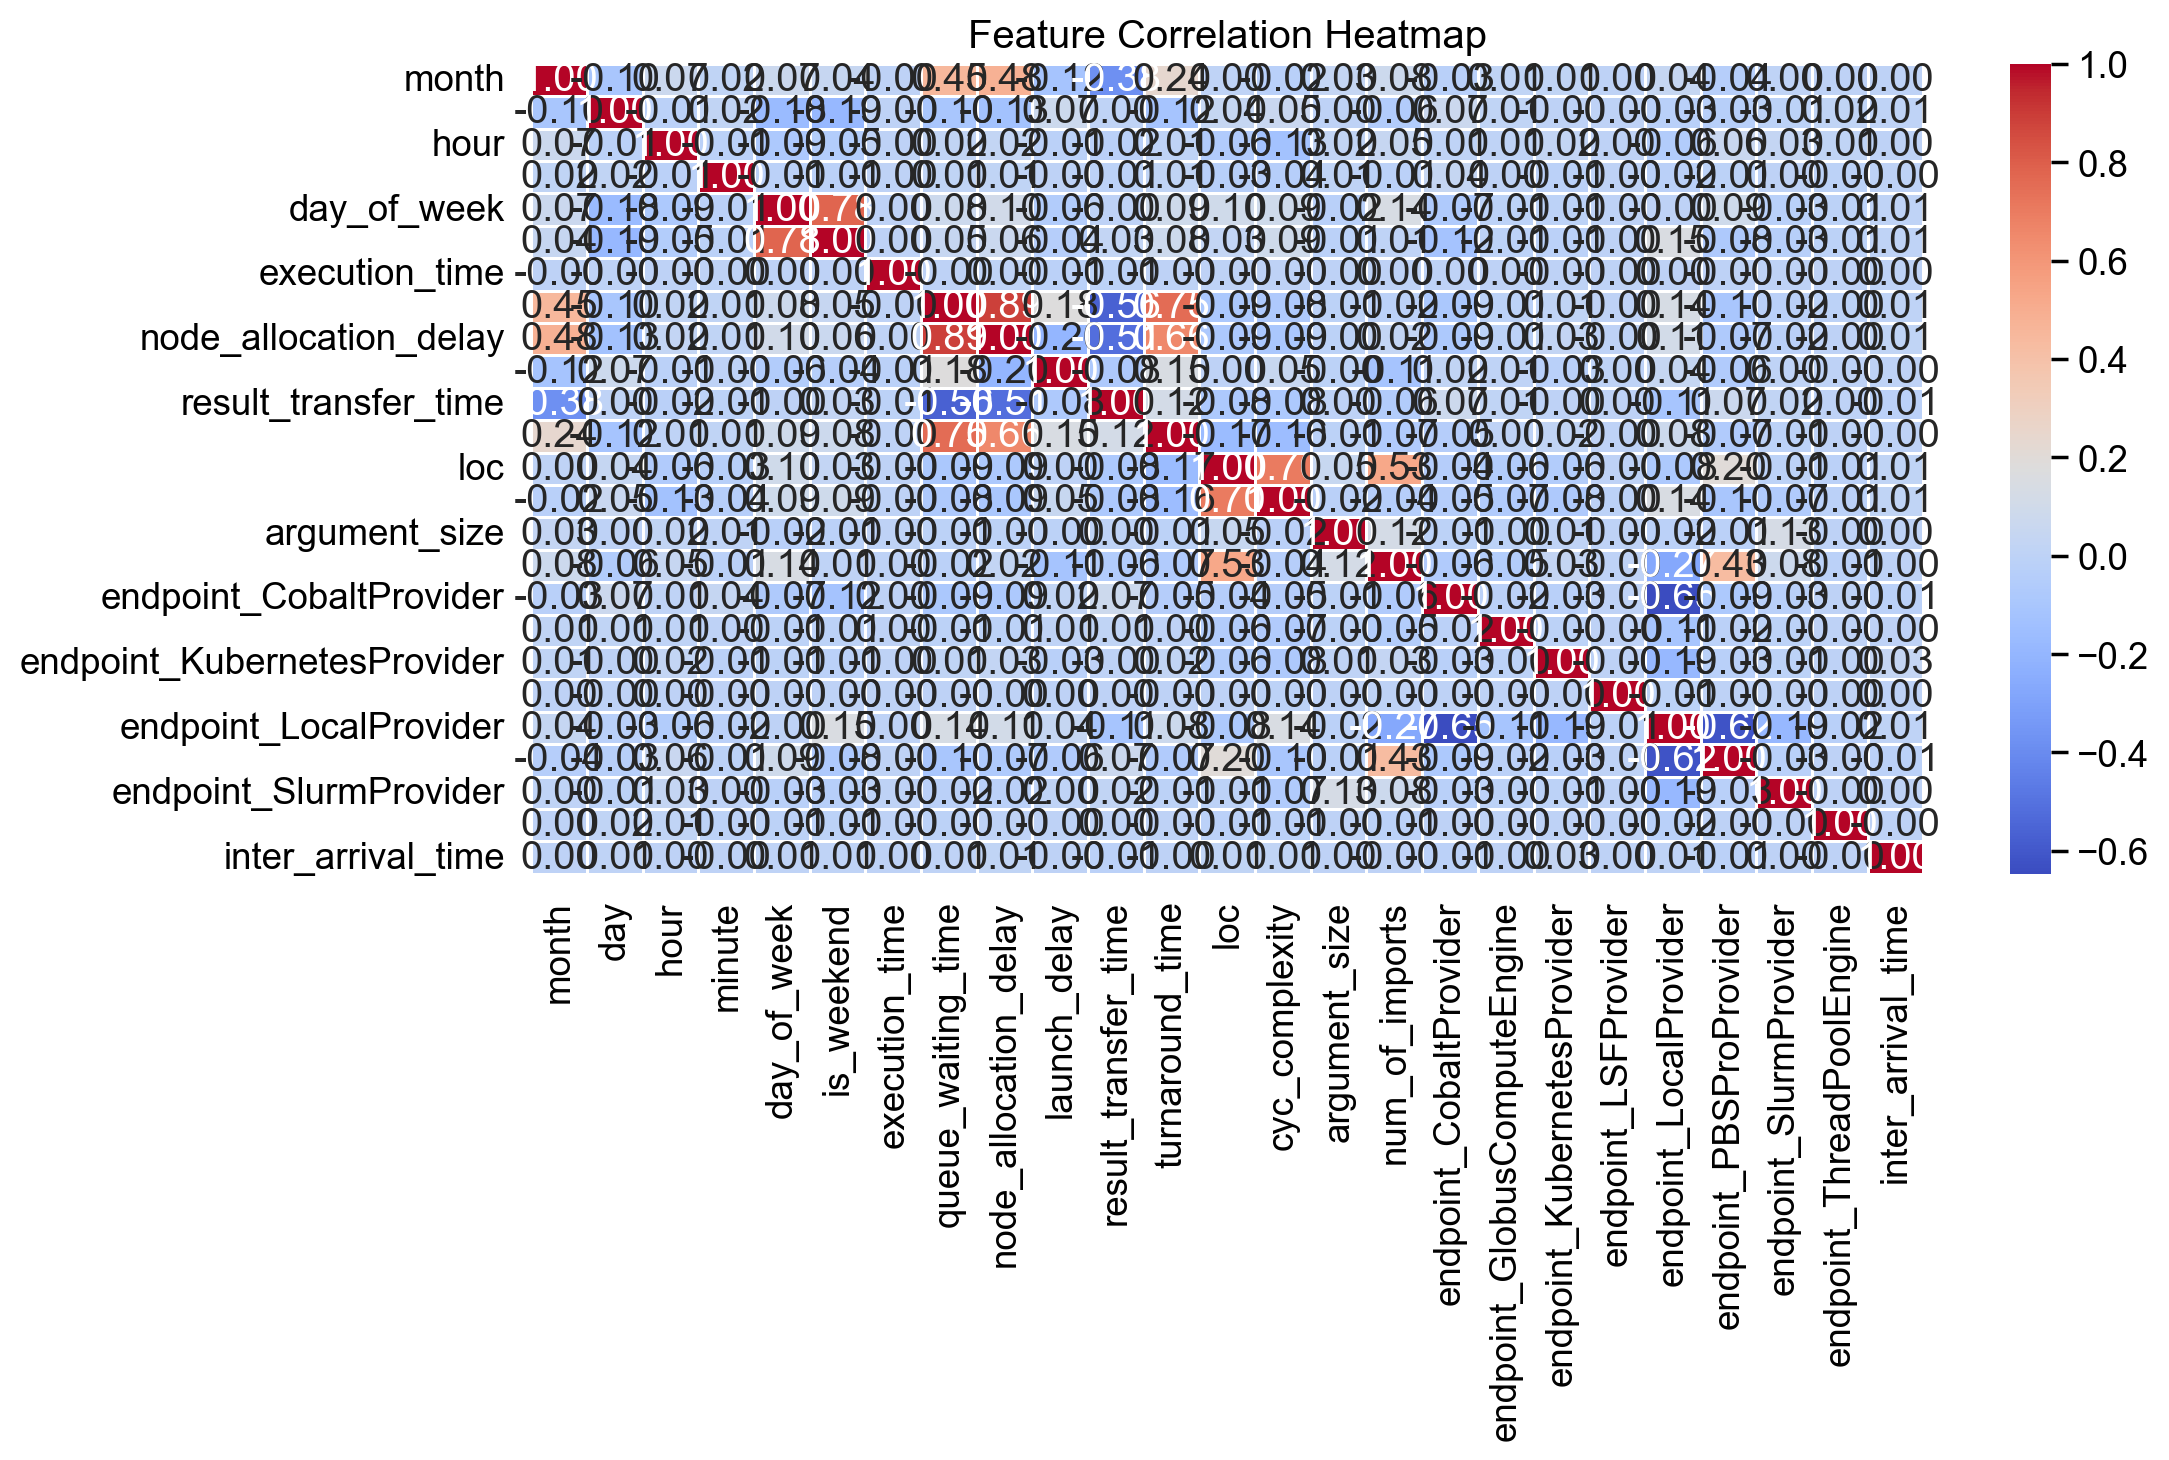

In [26]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [27]:
features_to_scale = ['execution_time', 'queue_waiting_time', 'node_allocation_delay', 'launch_delay', 'result_transfer_time', 'turnaround_time', 'loc', 'cyc_complexity', 'argument_size', 'num_of_imports', 'inter_arrival_time']
scaler = MinMaxScaler((0,1))
# scaler = StandardScaler()
# scaler = RobustScaler()
df_scaled = df.copy()

upper_limits = df_scaled[features_to_scale].quantile(0.99)
df_scaled[features_to_scale] = df_scaled[features_to_scale].clip(upper=upper_limits, axis=1)

df_scaled[features_to_scale] = scaler.fit_transform(df_scaled[features_to_scale])
df_scaled.head()

,month,day,hour,minute,day_of_week,is_weekend,execution_time,queue_waiting_time,node_allocation_delay,launch_delay,...,num_of_imports,endpoint_CobaltProvider,endpoint_GlobusComputeEngine,endpoint_KubernetesProvider,endpoint_LSFProvider,endpoint_LocalProvider,endpoint_PBSProProvider,endpoint_SlurmProvider,endpoint_ThreadPoolEngine,inter_arrival_time
1,11,28,0,0,0,0,0.999942,1.000000,1.000000,0.999998,...,0.111111,False,False,False,False,True,False,False,False,0.487654
2,11,28,0,0,0,0,0.999942,0.962351,0.960015,0.999998,...,0.111111,False,False,False,False,True,False,False,False,0.060200
3,11,28,0,1,0,0,0.999942,1.000000,1.000000,0.999998,...,0.111111,False,False,False,False,True,False,False,False,0.934912
4,11,28,0,1,0,0,0.999950,0.665602,0.998736,0.362440,...,0.111111,False,False,False,False,True,False,False,False,0.003114
5,11,28,0,2,0,0,0.999942,0.887210,0.668701,0.999998,...,0.111111,False,False,False,False,True,False,False,False,0.469131


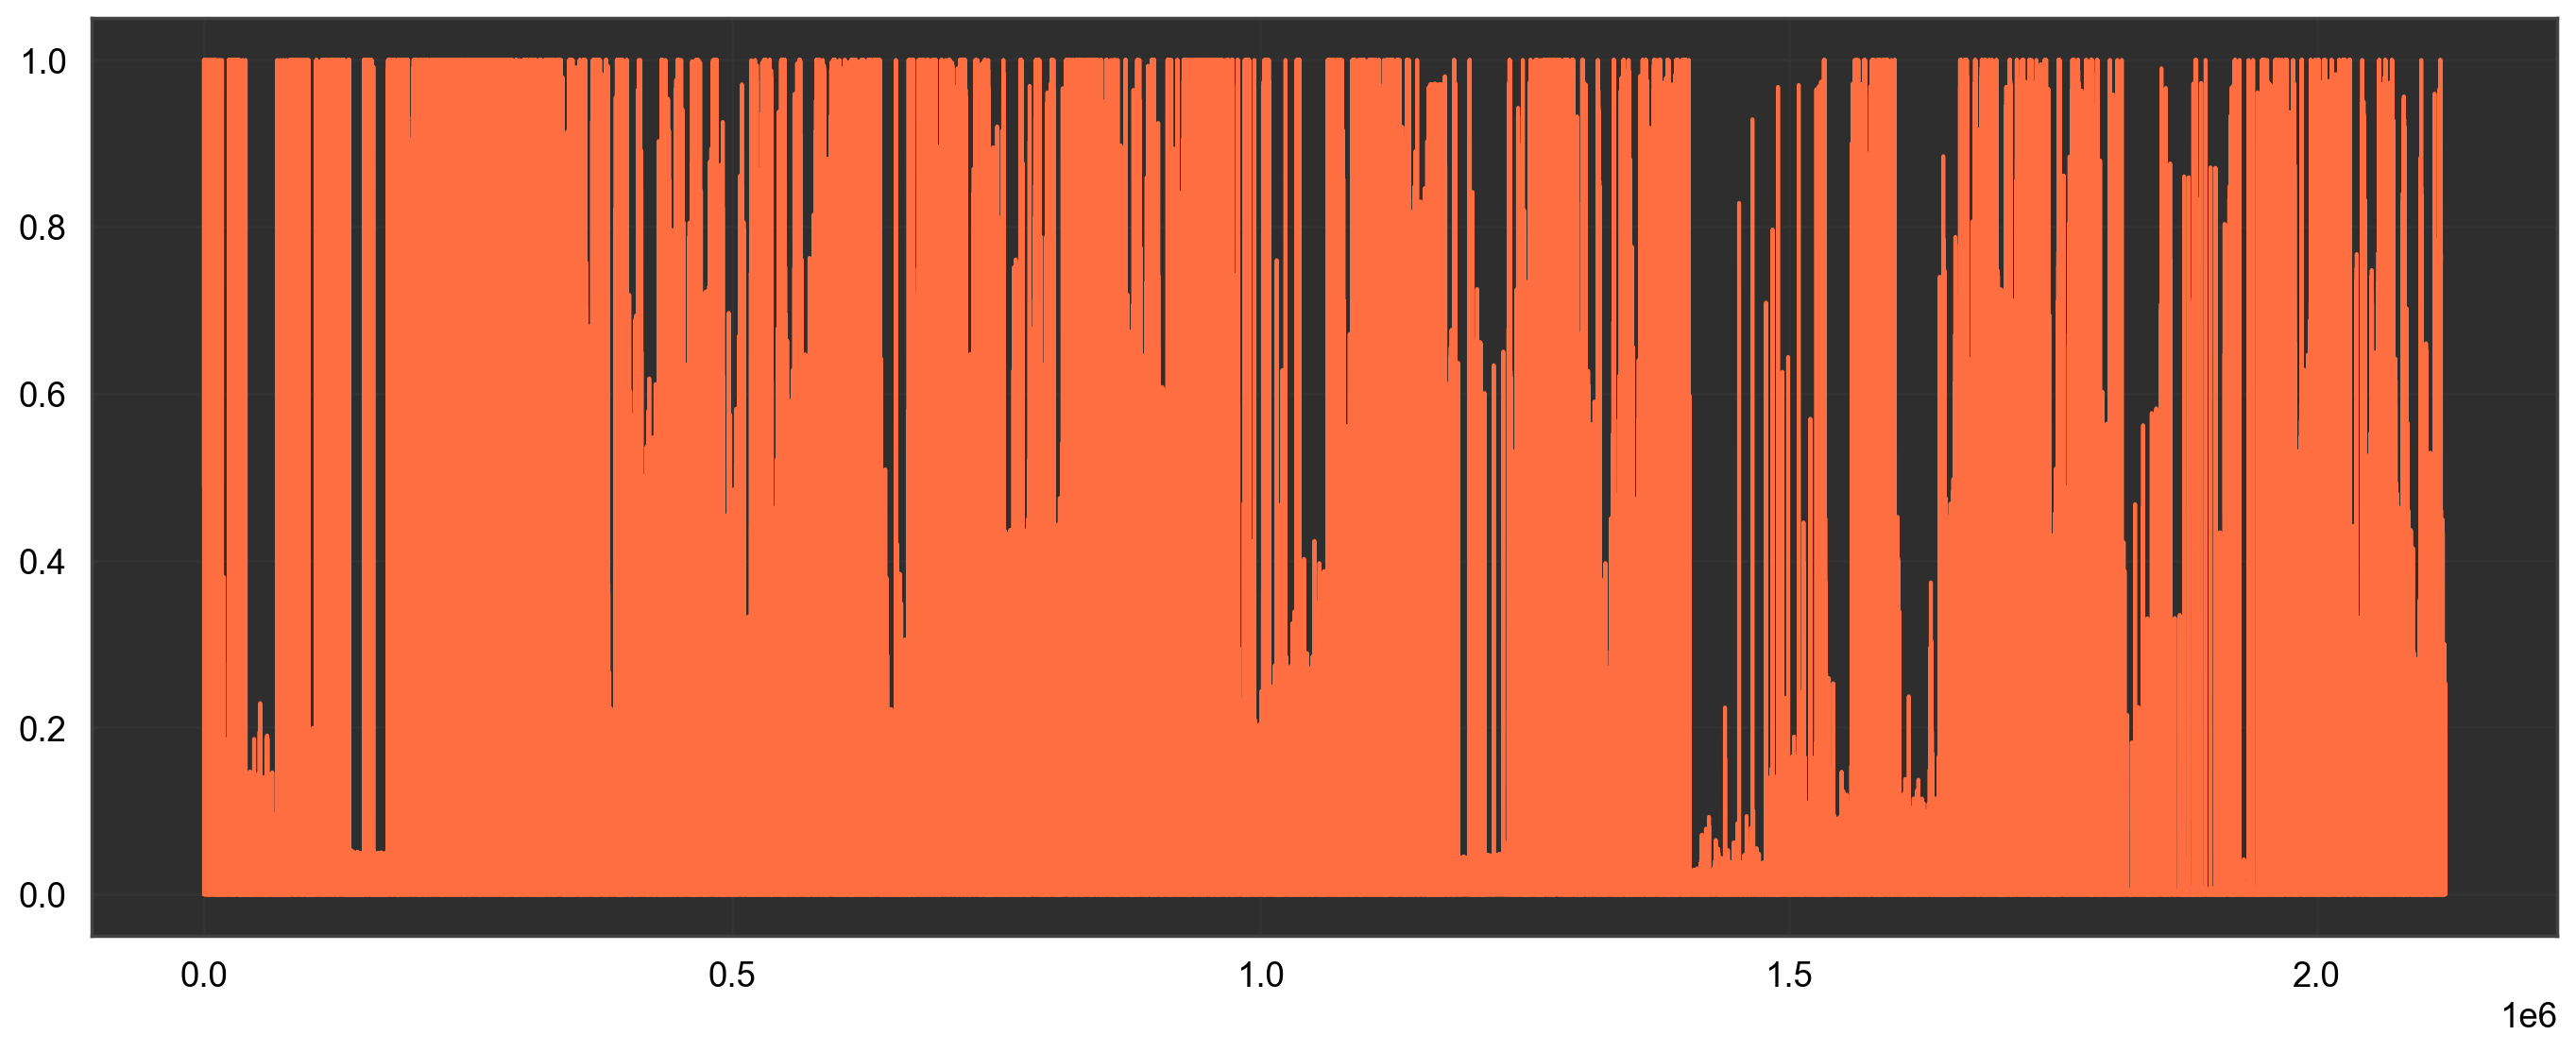

In [28]:
plt.figure(figsize=(15,6))
plt.plot(df_scaled.inter_arrival_time)
plt.show()

In [31]:
save_dir = "../Datasets/preprocessed/GlobusCompute/"
os.makedirs(save_dir, exist_ok=True)

train_df, temp_df = train_test_split(df_scaled, test_size=0.3, random_state=42, shuffle=True)
test_df, val_df = train_test_split(temp_df, test_size=1/3, random_state=42, shuffle=True)

train_df.to_csv(os.path.join(save_dir, "train.csv"), index=False)
test_df.to_csv(os.path.join(save_dir, "test.csv"), index=False)
val_df.to_csv(os.path.join(save_dir, "validation.csv"), index=False)

print("Train, Test, and Validation datasets saved successfully!")


Train, Test, and Validation datasets saved successfully!
